# clean data

In [1]:
import pandas as pd
import os

#Reading file
cwd=os.getcwd()
filename=cwd+ '/default of credit card clients.xls'
nanDict = {}
df = pd.read_excel(filename, header=1, skiprows=0, index_col=0, na_values=nanDict)
df.rename(index=str, columns={"default payment next month": "def_payment","PAY_0":"PAY_1"}, inplace=True)


In [2]:
#DEFINE CATEGORICAL AND CONTINUOUS VARIABLES
#CHECK VALUES TO MAKE SURE THERE ARE APPROPRIATE
cat = ["SEX","EDUCATION","MARRIAGE", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
cont = ['LIMIT_BAL','AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 
        'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] 
#for i in (cat):
#    values_counts=df[i].value_counts()
#    print("These are the observed values for " + str(i) + ":")
#    print(values_counts)

In [3]:
sex = [1,2]
education = [1,2,3,4]
marriage = [1,2,3]
payment = [0,1]
df = df[df["SEX"].isin(sex)]
df = df[df['EDUCATION'].isin(education)]
df = df[df['MARRIAGE'].isin(marriage)]
df = df[df['def_payment'].isin(payment)]
#We observe undocumented values for repayment status variables: -2 and 0.
#PAY-->4030 remaining observations-->too many 0 and -2
#len(df) #29601 remaining observations
#print(df)

In [4]:
# MOVE BAD VALUES TO ZERO
pay_var =  ['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for var in pay_var:
    vals = (df[var]== 0) | (df[var] == -2)
    df.loc[vals,var] = 0


In [5]:
# REMOVE OUTLIERS

outlier_df = df
def find_outliers(data,variable,numb):
    sorted(variable)
    outliers=[]
    non_outliers=[]
    q1,q3=np.percentile(variable,[25,75])
    iqr=q3-q1
    low_bound=q1-(numb*iqr)
    upper_bound=q3+(numb*iqr)
    #print(q1,q3,iqr,low_bound,upper_bound)
    for i in variable:
        if i>upper_bound or i<low_bound:
            outliers.append(i)
        else:
            non_outliers.append(i)
    data=data[variable.isin(non_outliers)]
    return data
    
for i in cont:
    outliers_datapoints=find_outliers(outlier_df, outlier_df[i], 3)
    outlier_df = outliers_datapoints
    print(len(outlier_df))
print(outlier_df[cont].describe().transpose()) 
outlier_df.keys()

NameError: name 'np' is not defined

(0, 24)

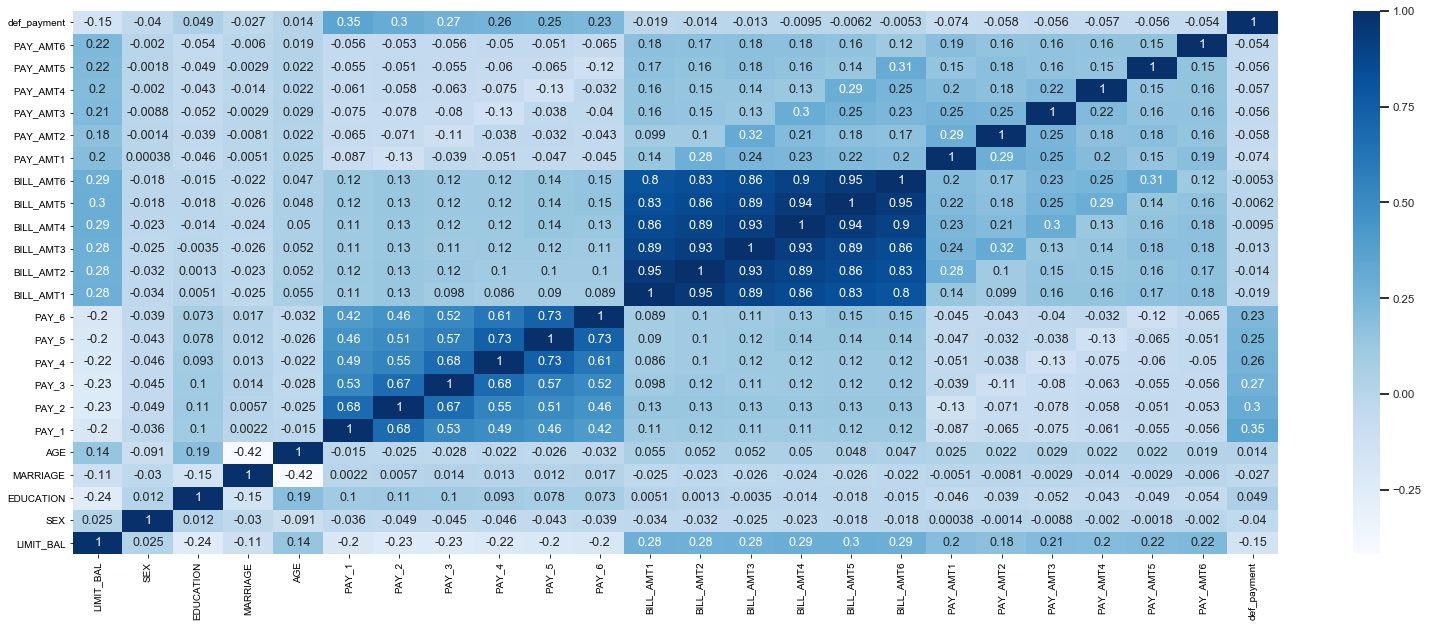

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#CORRELATION MATRIX OUTLIERS REMOVED
fig1, ax1 = plt.subplots(figsize = (27,10))
sns.set()
sns.set_context("talk", font_scale=0.7)
sns.heatmap(outlier_df.iloc[:,:].corr(), cmap='Blues', ax = ax1, annot=True)
plt.ylim(0,24)

In [7]:
#SEPARATE TARGETS AND TEST DATA
data_x= outlier_df.loc[:, outlier_df.columns != 'def_payment']
target= outlier_df.loc[:, outlier_df.columns == 'def_payment']
data_x.keys()
target.keys()

Index(['def_payment'], dtype='object')

# SCALE AND SPLIT DATA

In [8]:
from logistic_regression import LogisticRegression
from activation_functions import Activation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [9]:
# PREPARE DATA FOR BRUTE FORCE LOGISTIC REGRESSION

X = data_x
y = target


X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,test_size=0.2)

# scale continuous values and pay_# values
scaler = StandardScaler()
scale_vars = cont + pay_var
static_vars = ["SEX","EDUCATION","MARRIAGE"]
cont_train = X_train[scale_vars]
cont_test = X_test[scale_vars]
scaler.fit(cont_train)
cont_train = scaler.transform(cont_train)
cont_test = scaler.transform(cont_test)


X_train = np.c_[cont_train, X_train[static_vars].values]
X_test = np.c_[cont_test, X_test[static_vars].values]
y_train = y_train.values
y_test = y_test.values




# LOG REG NO PCA

ANALYSIS USING SIGMOID

In [116]:
from sklearn.model_selection import KFold

#LOOP OVER HYPERPARAMETERS 
eta_vec = np.logspace(-5, 1, 7)
lam_vec = np.logspace(-5, 1, 7)
test_accuracy_sig = np.zeros((len(eta_vec), len(lam_vec)))




for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        accuracy = 0
        for tr_idx, val_idx in kf.split(X_train):          
            bf = LogisticRegression(X_train[tr_idx], y_train[tr_idx], X_train[val_idx], y_train[val_idx], 
                                    ['SIGMOID'], eta = eta, lambd = lam, epochs = 100, batchs = 20)
            bf.train()
            bf.predict()
            pred = bf.score_binary()
            accuracy += bf.accuracy_metric(pred, y_train[val_idx])
        accuracy = accuracy/5
        test_accuracy_sig[i][j] = accuracy


/Users/douglas/Fall_2019/FYS4155/project2/activation_functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/Users/douglas/Fall_2019/FYS4155/project2/logistic_regression.py:59: RuntimeWarning: overflow encountered in matmul
  return self.activation.func(np.matmul(a,b))
/Users/douglas/Fall_2019/FYS4155/project2/logistic_regression.py:84: RuntimeWarning: overflow encountered in multiply
  gradient += self._lam*self._beta
/Users/douglas/Fall_2019/FYS4155/project2/logistic_regression.py:59: RuntimeWarning: invalid value encountered in matmul
  return self.activation.func(np.matmul(a,b))
/Users/douglas/Fall_2019/FYS4155/project2/logistic_regression.py:98: RuntimeWarning: invalid value encountered in greater
  self._predict[np.where(self._predict > .5)] = 1
/Users/douglas/Fall_2019/FYS4155/project2/logistic_regression.py:85: RuntimeWarning: overflow encountered in multiply
  self._beta -= self._eta * gradient


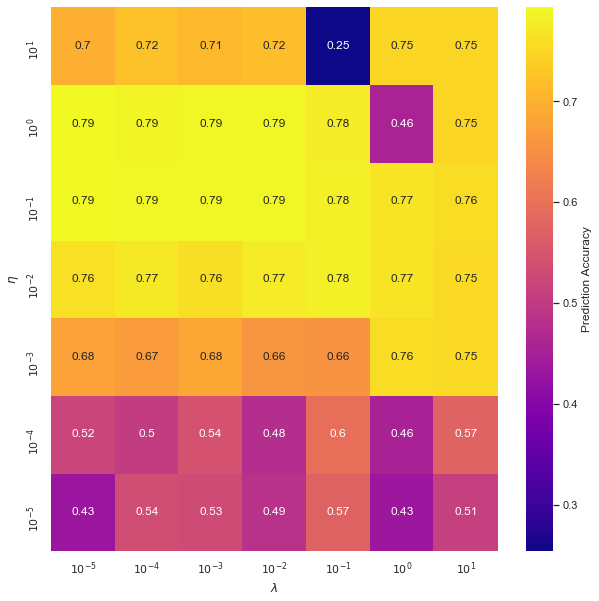

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
#PLOT OVER HYPERPARAMETERS BRUTE FORCE
#SIGMOID

sns.set()
labels = ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$','$10^1$',]
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_sig, annot=True, ax=ax, cmap="plasma", cbar_kws={'label': 'Prediction Accuracy'})
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.ylim(0,7)
plt.show()



FITTING TEST DATA

In [123]:
# USE ETA = 10E-1 AND LAMBDA = 10E-3
bf_sig = LogisticRegression(X_train, y_train, X_test, y_test, ['SIGMOID'], eta = 10e-1, lambd = 10e-3, 
                        epochs = 100, batchs = 20)
bf_sig.train()
bf_sig.predict()
pred = bf_sig.score_binary()
accuracy = bf_sig.accuracy_metric(pred, y_test)
print('Fit accuract to test data= ', accuracy)


Fit accuract to test data=  0.7934131736526946


ANALYSIS USING TANH

In [125]:
#LOOP OVER HYPERPARAMETERS 
eta_vec = np.logspace(-5, 1, 7)
lam_vec = np.logspace(-5, 1, 7)
test_accuracy_tanh = np.zeros((len(eta_vec), len(lam_vec)))




for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        accuracy = 0
        for tr_idx, val_idx in kf.split(X_train):          
            bf = LogisticRegression(X_train[tr_idx], y_train[tr_idx], X_train[val_idx], y_train[val_idx], 
                                    ['TANH'], eta = eta, lambd = lam, epochs = 100, batchs = 20)
            bf.train()
            bf.predict()
            pred = bf.score_binary()
            accuracy += bf.accuracy_metric(pred, y_train[val_idx])
        accuracy = accuracy/5
        test_accuracy_tanh[i][j] = accuracy

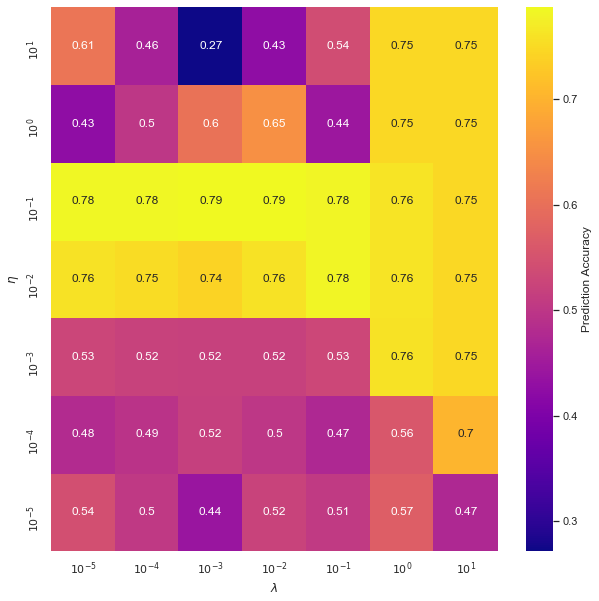

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
#PLOT OVER HYPERPARAMETERS BRUTE FORCE
#SIGMOID

sns.set()
labels = ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$','$10^1$',]
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_tanh, annot=True, ax=ax, cmap="plasma", cbar_kws={'label': 'Prediction Accuracy'})
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.ylim(0,7)
plt.show()

FITTING TEST DATA

In [127]:
# USE ETA = 10E-1 AND LAMBDA = 10E-3
bf_sig = LogisticRegression(X_train, y_train, X_test, y_test, ['TANH'], eta = 10e-1, lambd = 10e-3, 
                        epochs = 100, batchs = 20)
bf_sig.train()
bf_sig.predict()
pred = bf_sig.score_binary()
accuracy = bf_sig.accuracy_metric(pred, y_test)
print('Fit accuract to test data= ', accuracy)

Fit accuract to test data=  0.7961768770152003


# LOG REG USING PCA 

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 <a list of 7 Text xticklabel objects>)

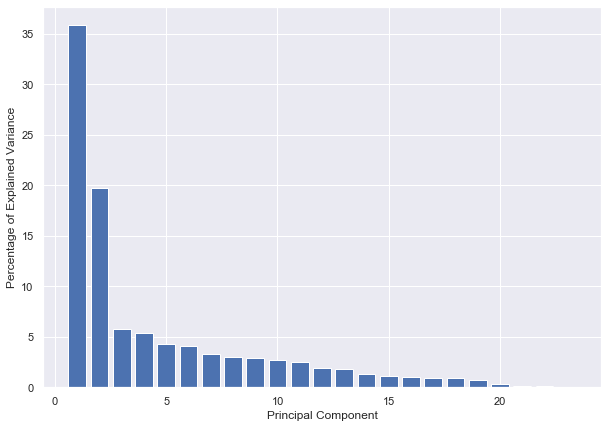

In [130]:
# ALL COMPONENTS VISUALIZED
from sklearn.decomposition import PCA

pca100 = PCA()
pca100_X_train = pca100.fit_transform(X_train)
per_var = pca100.explained_variance_ratio_*100
fig2 = plt.figure(figsize=(10,7))
plt.bar(x=range(1,len(per_var)+1),height=per_var)
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Component")
plt.xticks()


In [106]:
# TAKING PCA FOR 95% OF VARIANCE TO GET NEW TRAINING DATA

pca95 = PCA(n_components = 0.95)
pca95.fit(X_train)
X_train_95 = pca95.transform(X_train)
X_test_95 = pca95.transform(X_test)
loading_scores_1=pd.Series(pca95.components_[0])
loading_scores_2=pd.Series(pca95.components_[1])

fmt = '{:<9} {:<8} {:<8}'
print(fmt.format('Variable', 'PC1', 'PC2'))
for i in range(len(pca95.components_[0])):
    print(fmt.format(i+1, np.round(loading_scores_1[i], decimals = 5), np.round(loading_scores_2[i], decimals = 5)))


Variable  PC1      PC2     
1         0.03325  -0.20111
2         -4e-05   -0.01793
3         0.32503  -0.01028
4         0.33741  -0.00059
5         0.34495  0.00705 
6         0.3474   0.01649 
7         0.34546  0.02187 
8         0.34106  0.02437 
9         0.21632  -0.11539
10        0.21824  -0.12373
11        0.22393  -0.11992
12        0.21836  -0.12514
13        0.21672  -0.11592
14        0.20423  -0.11716
15        0.049    0.35052 
16        0.06449  0.37877 
17        0.05997  0.39042 
18        0.06302  0.40166 
19        0.06701  0.39416 
20        0.06668  0.36537 
21        0.00359  -0.01716
22        0.00696  0.05109 
23        -0.00081 0.0072  


SIGMOID ANALYSIS

In [134]:
from sklearn.model_selection import KFold

#LOOP OVER HYPERPARAMETERS 
eta_vec = np.logspace(-5, 1, 7)
lam_vec = np.logspace(-5, 1, 7)
test_accuracy_sig_95 = np.zeros((len(eta_vec), len(lam_vec)))




for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        accuracy = 0
        for tr_idx, val_idx in kf.split(X_train_95):          
            bf = LogisticRegression(X_train_95[tr_idx], y_train[tr_idx], X_train_95[val_idx], y_train[val_idx], 
                                    ['SIGMOID'], eta = eta, lambd = lam, epochs = 100, batchs = 20)
            bf.train()
            bf.predict()
            pred = bf.score_binary()
            accuracy += bf.accuracy_metric(pred, y_train[val_idx])
        accuracy = accuracy/5
        test_accuracy_sig_95[i][j] = accuracy

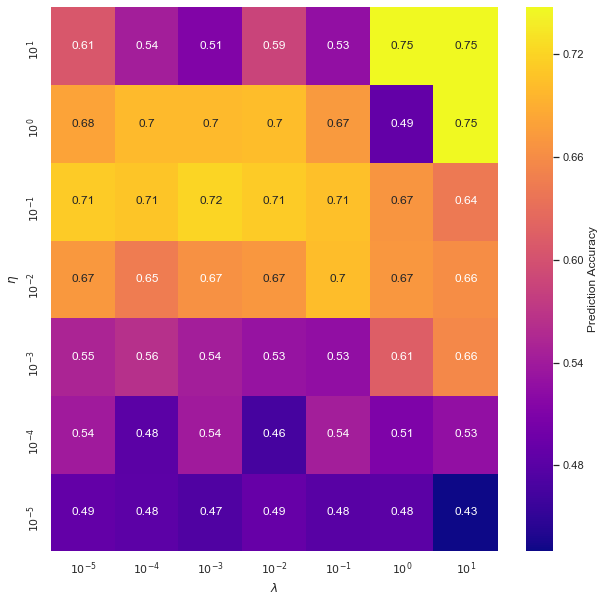

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
#PLOT OVER HYPERPARAMETERS PCA
#SIGMOID

sns.set()
labels = ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$','$10^1$',]
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_sig_95, annot=True, ax=ax, cmap="plasma", cbar_kws={'label': 'Prediction Accuracy'})
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.ylim(0,7)
plt.show()


In [137]:
# FIT TO TEST DATA USE ETA = 10E-1 AND LAMBDA = 10E-3
bf_sig = LogisticRegression(X_train_95, y_train, X_test_95, y_test, ['SIGMOID'], eta = 10e-1, lambd = 10e-3, 
                        epochs = 100, batchs = 20)
bf_sig.train()
bf_sig.predict()
pred = bf_sig.score_binary()
accuracy = bf_sig.accuracy_metric(pred, y_test)
print('Fit accuract to test data= ', accuracy)


Fit accuract to test data=  0.7167204053431598


TANH ANALYSIS

In [138]:
from sklearn.model_selection import KFold

#LOOP OVER HYPERPARAMETERS 
eta_vec = np.logspace(-5, 1, 7)
lam_vec = np.logspace(-5, 1, 7)
test_accuracy_tanh_95 = np.zeros((len(eta_vec), len(lam_vec)))




for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        accuracy = 0
        for tr_idx, val_idx in kf.split(X_train_95):          
            bf = LogisticRegression(X_train_95[tr_idx], y_train[tr_idx], X_train_95[val_idx], y_train[val_idx], 
                                    ['TANH'], eta = eta, lambd = lam, epochs = 100, batchs = 20)
            bf.train()
            bf.predict()
            pred = bf.score_binary()
            accuracy += bf.accuracy_metric(pred, y_train[val_idx])
        accuracy = accuracy/5
        test_accuracy_tanh_95[i][j] = accuracy

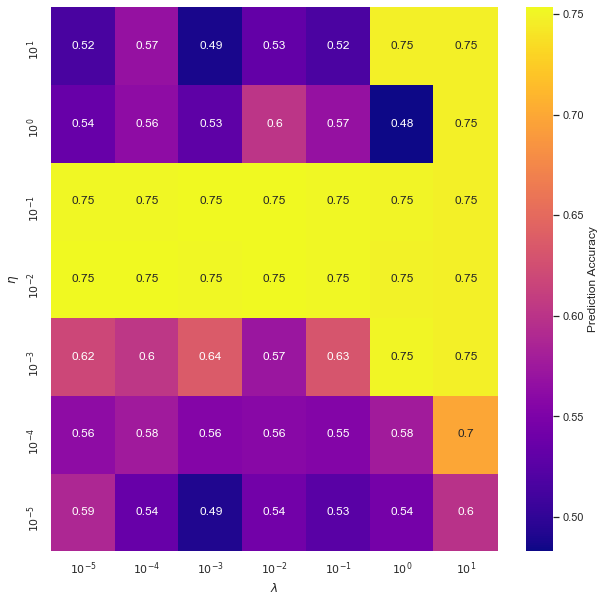

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
#PLOT OVER HYPERPARAMETERS PCA
#TANH

sns.set()
labels = ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$','$10^1$',]
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_tanh_95, annot=True, ax=ax, cmap="plasma", cbar_kws={'label': 'Prediction Accuracy'})
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.ylim(0,7)
plt.show()

In [146]:
# FIT TO TEST DATA USE ETA = 10E-1 AND LAMBDA = 10E-3
bf_tanh = LogisticRegression(X_train_95, y_train, X_test_95, y_test, ['TANH'], eta = 10e-2, lambd = 10e-3, 
                        epochs = 100, batchs = 20)
bf_tanh.train()
bf_tanh.predict()
pred = bf_tanh.score_binary()
accuracy = bf_tanh.accuracy_metric(pred, y_test)
print('Fit accuract to test data= ', accuracy)

Fit accuract to test data=  0.7581759557807461


# NEURAL NET ANALYSIS

In [10]:
from activation_functions import Activation
from neural_net import Neural_Network

In [13]:
from sklearn.model_selection import KFold
import numpy as np
# 10 neurons, 2 layers

eta_vec = np.logspace(-5, 1, 7)
lam_vec = np.logspace(-5, 1, 7)
test_accuracy_NN = np.zeros((len(eta_vec), len(lam_vec)))

for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        accuracy = 0
        for tr_idx, val_idx in kf.split(X_train):          
            NN = Neural_Network('REGRESSOR', X_train[tr_idx], y_train[tr_idx], ['SIGMOID', 'SIGMOID', 'SIGMOID'], 
                                  epochs = 10, batchsize = 100, iterations = None, hidden_layers =2, 
                                  hidden_neurons = [10,10], eta = eta, lambd = lam)
            NN.train(X_train[tr_idx], y_train[tr_idx])
            _, prob = NN.feed_out_regressor(X_train[val_idx])
            pred = NN.score_binary(prob[-1])
            accuracy += NN.accuracy(pred, y_train[val_idx])
        accuracy = accuracy/5
        test_accuracy_NN[i][j] = accuracy

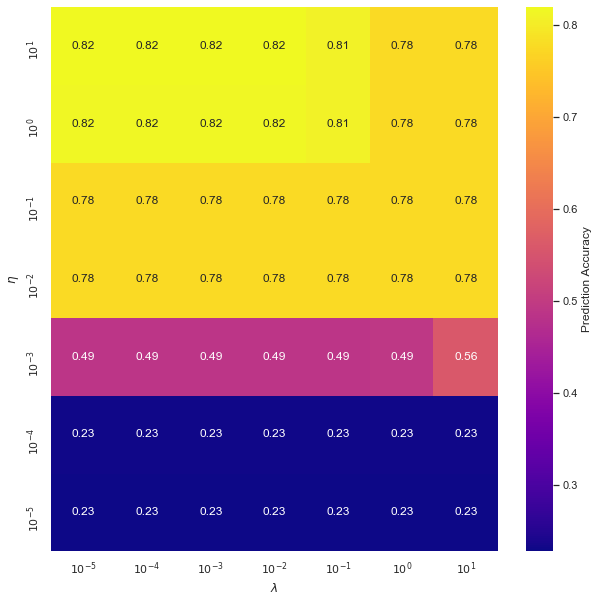

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
#PLOT OVER HYPERPARAMETER 10, 10

sns.set()
labels = ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$','$10^1$',]
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_NN, annot=True, ax=ax, cmap="plasma", cbar_kws={'label': 'Prediction Accuracy'})
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.ylim(0,7)
plt.show()

In [17]:
# REST BEST VALUES FROM KFOLD
NN = Neural_Network('REGRESSOR', X_train, y_train, ['SIGMOID', 'SIGMOID', 'SIGMOID'], 
                                  epochs = 10, batchsize = 100, iterations = None, hidden_layers =2, 
                                  hidden_neurons = [10,10], eta = 1, lambd = 10e-3)
NN.train(X_train, y_train)
_, prob = NN.feed_out_regressor(X_test)
pred = NN.score_binary(prob[-1])
accuracy = NN.accuracy(pred, y_test)
print(accuracy)

0.8172605978719811


In [18]:
# 15 neurons, 2 layers

eta_vec = np.logspace(-5, 1, 7)
lam_vec = np.logspace(-5, 1, 7)
test_accuracy_NN = np.zeros((len(eta_vec), len(lam_vec)))

for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        accuracy = 0
        for tr_idx, val_idx in kf.split(X_train):          
            NN = Neural_Network('REGRESSOR', X_train[tr_idx], y_train[tr_idx], ['SIGMOID', 'SIGMOID', 'SIGMOID'], 
                                  epochs = 10, batchsize = 100, iterations = None, hidden_layers =2, 
                                  hidden_neurons = [15,15], eta = eta, lambd = lam)
            NN.train(X_train[tr_idx], y_train[tr_idx])
            _, prob = NN.feed_out_regressor(X_train[val_idx])
            pred = NN.score_binary(prob[-1])
            accuracy += NN.accuracy(pred, y_train[val_idx])
        accuracy = accuracy/5
        test_accuracy_NN[i][j] = accuracy

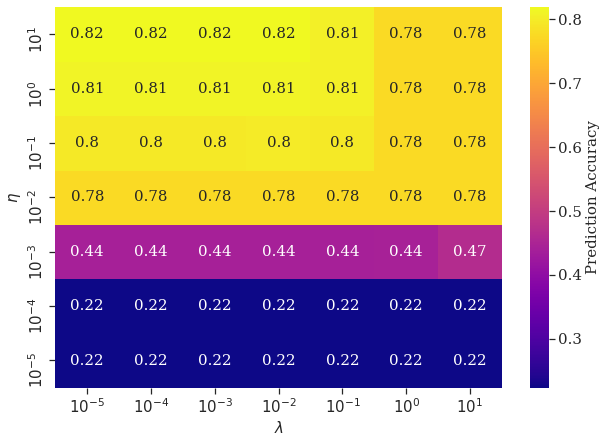

In [197]:
#PLOT OVER HYPERPARAMETER 15, 15

fig, ax1 = plt.subplots(figsize = (10, 7))
labels = ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$','$10^1$',]


sns.set_style('dark',{'axes.edgecolor': '.1','xtick.bottom': True,'ytick.left': True,'axes.grid':True,
                      'grid.color':'white','font.family':['serif'],'font.serif':['serif'],'xtick.bottom':True,
                      'ytick.left':True})

sns.heatmap(test_accuracy_NN, annot=True, ax=ax1, cmap="plasma", cbar_kws={'label': 'Prediction Accuracy'})
ax1.set_xticklabels(labels)
ax1.set_yticklabels(labels)
ax1.set_ylabel("$\eta$")
ax1.set_xlabel("$\lambda$")



plt.ylim(0,7)
plt.show()

In [22]:
# REST BEST VALUES FROM KFOLD
NN = Neural_Network('REGRESSOR', X_train, y_train, ['SIGMOID', 'SIGMOID', 'SIGMOID'], 
                                  epochs = 100, batchsize = 100, iterations = None, hidden_layers =2, 
                                  hidden_neurons = [15,15], eta = 1, lambd = 10e-3)
NN.train(X_train, y_train)
_, prob = NN.feed_out_regressor(X_test)
pred = NN.score_binary(prob[-1])
accuracy = NN.accuracy(pred, y_test)
print(accuracy)

0.8189495017733491


In [72]:
# TESTING DIFFERENT EPOCHS AND BATCH SIZES 15,15
epoch_vals = np.concatenate((np.array([1]),np.arange(10,101,10)), axis=0) #1, 10, 20, ...100
batch_vals = [8,16,32,64,128,256] #2^N
accuracy_mat = np.zeros((len(epoch_vals),len(batch_vals)))
for i, batch in enumerate(batch_vals):
    for j, val in enumerate(epoch_vals):
        NN = Neural_Network('REGRESSOR', X_train, y_train, ['SIGMOID', 'SIGMOID', 'SIGMOID'], 
                                      epochs = val, batchsize = batch, iterations = None, hidden_layers =2, 
                                      hidden_neurons = [15,15], eta = 1, lambd = 10e-3)
        NN.train(X_train, y_train)
        _, prob = NN.feed_out_regressor(X_test)
        pred = NN.score_binary(prob[-1])
        acc = NN.accuracy(pred, y_test)
        accuracy_mat[j][i] = acc
        

{'axes.facecolor': '#EAEAF2', 'axes.edgecolor': '.1', 'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': '.15', 'figure.facecolor': 'white', 'grid.color': 'white', 'grid.linestyle': '-', 'text.color': '.15', 'xtick.color': '.15', 'ytick.color': '.15', 'xtick.direction': 'out', 'ytick.direction': 'out', 'lines.solid_capstyle': 'round', 'patch.edgecolor': 'w', 'image.cmap': 'rocket', 'font.family': ['serif'], 'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'], 'patch.force_edgecolor': True, 'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'ytick.right': False, 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': True, 'axes.spines.top': True}


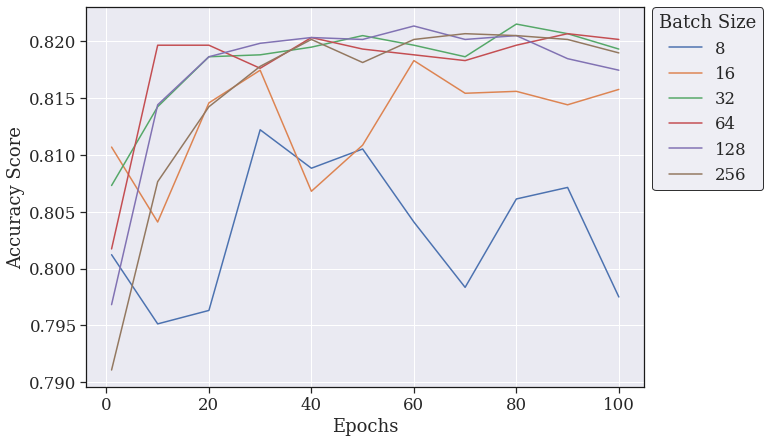

In [119]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.5)
sns.set_style('dark',{'axes.edgecolor': '.1','xtick.bottom': True,'ytick.left': True,'axes.grid':True,
                      'grid.color':'white','font.family':['serif'],'font.serif':['serif']})

ax.plot(epoch_vals, accuracy_mat[:,0], label = '8')
ax.plot(epoch_vals, accuracy_mat[:,1], label = '16')
ax.plot(epoch_vals, accuracy_mat[:,2], label = '32')
ax.plot(epoch_vals, accuracy_mat[:,3], label = '64')
ax.plot(epoch_vals, accuracy_mat[:,4], label = '128')
ax.plot(epoch_vals, accuracy_mat[:,5], label = '256')
leg = ax.legend(title = 'Batch Size',bbox_to_anchor=(1, 1.02), fancybox = True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy Score')

print(sns.axes_style())

In [ ]:
# NEURAL NET WITH TANH 

In [198]:
eta_vec = np.logspace(-5, 1, 7)
lam_vec = np.logspace(-5, 1, 7)
test_accuracy_NN_tanh = np.zeros((len(eta_vec), len(lam_vec)))

for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        accuracy = 0
        for tr_idx, val_idx in kf.split(X_train):          
            NN = Neural_Network('REGRESSOR', X_train[tr_idx], y_train[tr_idx], ['TANH', 'TANH', 'TANH'], 
                                  epochs = 10, batchsize = 100, iterations = None, hidden_layers =2, 
                                  hidden_neurons = [10,10], eta = eta, lambd = lam)
            NN.train(X_train[tr_idx], y_train[tr_idx])
            _, prob = NN.feed_out_regressor(X_train[val_idx])
            pred = NN.score_binary(prob[-1])
            accuracy += NN.accuracy(pred, y_train[val_idx])
        accuracy = accuracy/5
        test_accuracy_NN_tanh[i][j] = accuracy

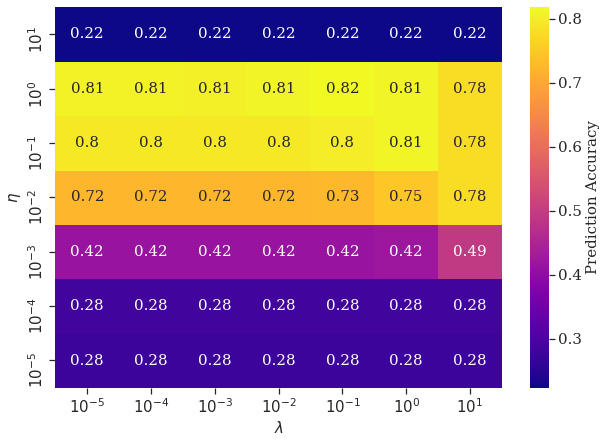

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
#PLOT OVER HYPERPARAMETER 10, 10

labels = ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$','$10^1$',]
fig, ax = plt.subplots(figsize = (10, 7))
sns.set_style('dark',{'axes.edgecolor': '.1','xtick.bottom': True,'ytick.left': True,'axes.grid':True,
                      'grid.color':'white','font.family':['serif'],'font.serif':['serif'],'xtick.bottom':True,
                      'ytick.left':True})
sns.heatmap(test_accuracy_NN_tanh, annot=True, ax=ax, cmap="plasma", cbar_kws={'label': 'Prediction Accuracy'})
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.ylim(0,7)
plt.show()

In [203]:
#15, 15
eta_vec = np.logspace(-5, 1, 7)
lam_vec = np.logspace(-5, 1, 7)
test_accuracy_NN_tanh = np.zeros((len(eta_vec), len(lam_vec)))

for i, eta in enumerate(eta_vec):
    for j, lam in enumerate(lam_vec):
        kf = KFold(n_splits = 5, shuffle = True)
        accuracy = 0
        for tr_idx, val_idx in kf.split(X_train):          
            NN = Neural_Network('REGRESSOR', X_train[tr_idx], y_train[tr_idx], ['TANH', 'TANH', 'TANH'], 
                                  epochs = 10, batchsize = 100, iterations = None, hidden_layers =2, 
                                  hidden_neurons = [15,15], eta = eta, lambd = lam)
            NN.train(X_train[tr_idx], y_train[tr_idx])
            _, prob = NN.feed_out_regressor(X_train[val_idx])
            pred = NN.score_binary(prob[-1])
            accuracy += NN.accuracy(pred, y_train[val_idx])
        accuracy = accuracy/5
        test_accuracy_NN_tanh[i][j] = accuracy

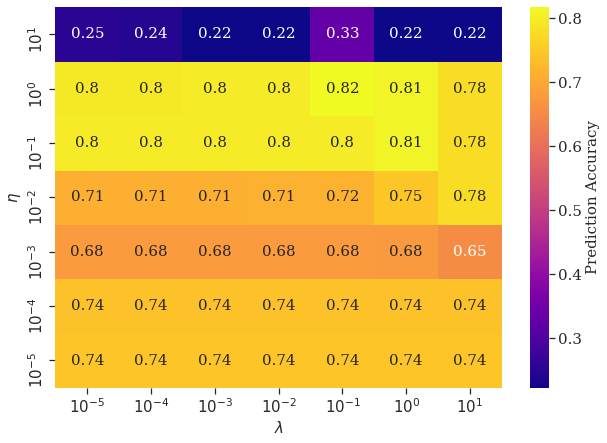

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt
#PLOT OVER HYPERPARAMETER 10, 10

labels = ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^0$','$10^1$',]
fig, ax = plt.subplots(figsize = (10, 7))
sns.set_style('dark',{'axes.edgecolor': '.1','xtick.bottom': True,'ytick.left': True,'axes.grid':True,
                      'grid.color':'white','font.family':['serif'],'font.serif':['serif'],'xtick.bottom':True,
                      'ytick.left':True})
sns.heatmap(test_accuracy_NN_tanh, annot=True, ax=ax, cmap="plasma", cbar_kws={'label': 'Prediction Accuracy'})
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.ylim(0,7)
plt.show()

In [216]:
NN1 = Neural_Network('REGRESSOR', X_train, y_train, ['TANH', 'TANH', 'TANH'], 
                                      epochs = 20, batchsize = 100, iterations = None, hidden_layers =2, 
                                      hidden_neurons = [15,15], eta = 10e0, lambd = 10e-1)
NN1.train(X_train, y_train)
_, prob = NN.feed_out_regressor(X_test)
pred = NN1.score_binary(prob[-1])
acc = NN1.accuracy(pred, y_test)
print(acc)

0.2224286438101672


In [209]:
# TESTING DIFFERENT EPOCHS AND BATCH SIZES 15,15
epoch_vals = np.concatenate((np.array([1]),np.arange(10,101,10)), axis=0) #1, 10, 20, ...100
batch_vals = [8,16,32,64,128,256] #2^N
accuracy_mat_tanh = np.zeros((len(epoch_vals),len(batch_vals)))
for i, batch in enumerate(batch_vals):
    for j, val in enumerate(epoch_vals):
        NN = Neural_Network('REGRESSOR', X_train, y_train, ['TANH', 'TANH', 'TANH'], 
                                      epochs = val, batchsize = batch, iterations = None, hidden_layers =2, 
                                      hidden_neurons = [15,15], eta = 10e0, lambd = 10e-1)
        NN.train(X_train, y_train)
        _, prob = NN.feed_out_regressor(X_test)
        pred = NN.score_binary(prob[-1])
        acc = NN.accuracy(pred, y_test)
        print(acc)
        accuracy_mat_tanh[j][i] = acc

0.2224286438101672
0.2224286438101672


KeyboardInterrupt: 

{'axes.facecolor': '#EAEAF2', 'axes.edgecolor': '.1', 'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': '.15', 'figure.facecolor': 'white', 'grid.color': 'white', 'grid.linestyle': '-', 'text.color': '.15', 'xtick.color': '.15', 'ytick.color': '.15', 'xtick.direction': 'out', 'ytick.direction': 'out', 'lines.solid_capstyle': 'round', 'patch.edgecolor': 'w', 'image.cmap': 'rocket', 'font.family': ['serif'], 'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'], 'patch.force_edgecolor': True, 'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'ytick.right': False, 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': True, 'axes.spines.top': True}


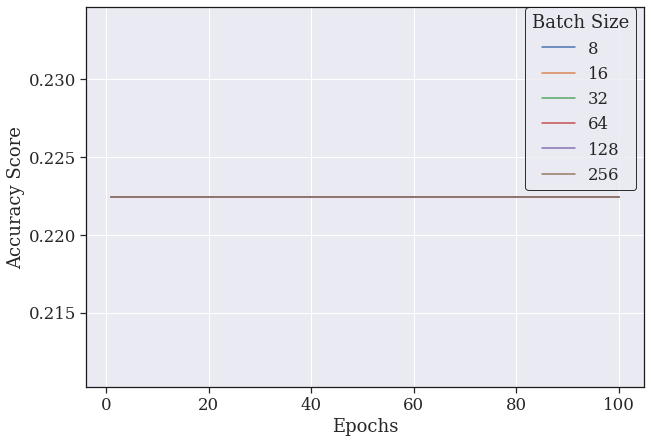

In [207]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.5)
sns.set_style('dark',{'axes.edgecolor': '.1','xtick.bottom': True,'ytick.left': True,'axes.grid':True,
                      'grid.color':'white','font.family':['serif'],'font.serif':['serif']})

ax.plot(epoch_vals, accuracy_mat_tanh[:,0], label = '8')
ax.plot(epoch_vals, accuracy_mat_tanh[:,1], label = '16')
ax.plot(epoch_vals, accuracy_mat_tanh[:,2], label = '32')
ax.plot(epoch_vals, accuracy_mat_tanh[:,3], label = '64')
ax.plot(epoch_vals, accuracy_mat_tanh[:,4], label = '128')
ax.plot(epoch_vals, accuracy_mat_tanh[:,5], label = '256')
leg = ax.legend(title = 'Batch Size',bbox_to_anchor=(1, 1.02), fancybox = True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy Score')

print(sns.axes_style())